In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
from IPython.display import display
from sklearn import metrics
from sklearn.model_selection import train_test_split
pd.set_option('display.float_format', lambda x:'%.5f' % x)
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from scipy.sparse import hstack
from scipy.sparse import csr_matrix

import lightgbm as lgb
import xgboost

## Use google colab environment run the code

In [2]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
train = pd.read_csv('gdrive/My Drive/kaggle/train.tsv',delimiter='\t', low_memory=True)

# train = pd.read_csv('train.tsv', delimiter='\t', low_memory=True)
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.00000,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.00000,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.00000,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.00000,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.00000,0,Complete with certificate of authenticity


In [4]:
def split_cat(text):
    try: return text.split("/")
    except: return ("No Label", "No Label", "No Label")
train["general_cat"], train["sub_cat1"], train["sub_cat2"] = zip(*train['category_name'].apply(lambda x: split_cat(x)))
train.drop("category_name", axis=1).head()


,train_id,name,item_condition_id,brand_name,price,shipping,item_description,general_cat,sub_cat1,sub_cat2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,NaN,10.00000,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Razer,52.00000,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Target,10.00000,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,NaN,35.00000,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,NaN,44.00000,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


## replace missing data

In [5]:
train['general_cat'].fillna(value='missing', inplace=True)
train['sub_cat1'].fillna(value='missing', inplace=True)
train['sub_cat2'].fillna(value='missing', inplace=True)
train['brand_name'].fillna(value='missing', inplace=True)
train['item_description'].fillna(value='missing', inplace=True)
# rank by the frequency of brand name
train['brand_name'].value_counts().head()

missing              632682
PINK                  54088
Nike                  54043
Victoria's Secret     48036
LuLaRoe               31024
Name: brand_name, dtype: int64

In [6]:
# rank by the frequency of item_description
train['item_description'].value_counts().head()

No description yet    82489
New                    4099
Brand new              3058
Good condition         1274
Great condition        1158
Name: item_description, dtype: int64

## Convert training data type to "category"

In [7]:
#-------------------------
train['general_cat'] = train['general_cat'].astype('category')
train['sub_cat1'] = train['sub_cat1'].astype('category')
train['sub_cat2'] = train['sub_cat2'].astype('category')
train['item_condition_id'] = train['item_condition_id'].astype('category')
train.dtypes

train_id                int64
name                   object
item_condition_id    category
category_name          object
brand_name             object
price                 float64
shipping                int64
item_description       object
general_cat          category
sub_cat1             category
sub_cat2             category
dtype: object

## Convert words to a matrix of token counts

In [8]:
vec_words = CountVectorizer(min_df=5)
X_name = vec_words.fit_transform(train['name'])
frequency = np.asarray(X_name.sum(axis=0)).ravel().tolist()
# check the high frequency words of 'name' column
counts_cv = pd.DataFrame({'term': vec_words.get_feature_names(), 'occurrences': frequency})
counts_cv.sort_values(by='occurrences', ascending=False).head(10)

,term,occurrences
17561,pink,83939
4489,bundle,77834
16008,new,76890
20753,size,73412
14009,lularoe,63445
9325,for,59552
3646,black,56397
16096,nike,46471
2222,and,46226
24443,vs,44374


## check 3 different categories of high frequency words

In [9]:
combine_category = [train["general_cat"], train["sub_cat1"], train["sub_cat2"]]
categories = [None] * 3

for i in range(3):
    categories[i] = vec_words.fit_transform(combine_category[i])
    print("general category for: ",'{category}'.format(category = combine_category[i].name))
    print (categories[i].shape)
    frequency = np.asarray(categories[i].sum(axis=0)).ravel().tolist()
    counts_vectory = pd.DataFrame({'term': vec_words.get_feature_names(), 'occurrences': frequency})
    print (counts_vectory.sort_values(by='occurrences', ascending=False).head())    

general category for:  general_cat
(1482535, 14)
           term  occurrences
13        women       664385
0        beauty       207828
5          kids       171689
2   electronics       122690
7           men        93680
general category for:  sub_cat1
(1482535, 143)
            term  occurrences
6        apparel       137301
3    accessories       136500
10      athletic       134383
130         tops       127551
79        makeup       124624
general category for:  sub_cat2
(1482535, 856)
            term  occurrences
658       shirts        97349
417     leggings        66871
520        pants        66732
5    accessories        63113
768       tights        60177


## Convert words to a matrix of TF-IDF features.

1. remove the english stop words.
2. return the words-document matrix.
3. Arrange item_description words by weights

In [10]:
tfidf = TfidfVectorizer(max_features=1000, ngram_range=(1, 3), stop_words='english')
vectorised_train = tfidf.fit_transform(train['item_description'])
weights = np.asarray(vectorised_train.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': tfidf.get_feature_names(), 'weight': weights})
weights_df.sort_values(by='weight', ascending=False).head()

,term,weight
244,description,0.05652
551,new,0.05044
797,size,0.04497
205,condition,0.03169
111,brand,0.03153


## Binarize words labels

labeling 'brand_name', each brand falls under 0 or 1.

In [11]:
lb = LabelBinarizer(sparse_output=True)
label = lb.fit_transform(train['brand_name'])
frequency = np.asarray(label.sum(axis=0)).ravel().tolist()
counts_cv = pd.DataFrame({'term': lb.classes_, 'occurrences': frequency})
counts_cv.sort_values(by='occurrences', ascending=False).head()

,term,occurrences
4786,missing,632682
3221,PINK,54088
3057,Nike,54043
4504,Victoria's Secret,48036
2604,LuLaRoe,31024


Dummy variable generates a large number of sparse matrices, using a class called csr_matrix that can process sparse matrices efficiently.

In [12]:
merge_matrix = csr_matrix(pd.get_dummies(train['item_condition_id'],train['shipping'],sparse=True).values)
merge_matrix

<1482535x5 sparse matrix of type '<class 'numpy.uint8'>'
	with 1482535 stored elements in Compressed Sparse Row format>

In [13]:
sparse_matrix = hstack([merge_matrix, vectorised_train, label, categories[0],categories[1], categories[2], X_name]).tocsr()
sparse_matrix.shape

(1482535, 32387)

## Split data into train and test

Define the Root Mean Squared Logarithmic Error (RMSLE) function

In [0]:
from sklearn.model_selection import train_test_split

X = sparse_matrix
y = np.log1p(train["price"])
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.1, random_state = 144) 


def rmsle(y, y0):
    return np.sqrt(np.mean(np.power(np.log1p(y)-np.log1p(y0), 2)))


# Lightgbm Model

set up the maximum step equal to 5000

## LGB model 1

Hyper parameter value: 'learning_rate': 0.65,
        'application': 'regression',
        'max_depth': 3,
        'num_leaves': 60,
        'verbosity': -1,
        'metric': 'RMSE',
        'data_random_seed': 1,
        'bagging_fraction': 0.5,
        'nthread': 4

In [15]:
train_model = lgb.Dataset(train_X, label=train_y)
test_model = lgb.Dataset(test_X, label=test_y)
watchlistL1 = [train_model, test_model]
para_meter1 = {
        'learning_rate': 0.65,
        'application': 'regression',
        'max_depth': 3,
        'num_leaves': 60,
        'verbosity': -1,
        'metric': 'RMSE',
        'data_random_seed': 1,
        'bagging_fraction': 0.5,
        'nthread': 4
    }
lgb_model = lgb.train(para_meter1, train_set=train_model, num_boost_round=5000, valid_sets=watchlistL1,early_stopping_rounds=5000, verbose_eval=500) 
lgb_pred = lgb_model.predict(test_X)
rmsleL1 = rmsle(lgb_pred, test_y)
print ("LightGBM1 RMSLE = " + str(rmsleL1))

Training until validation scores don't improve for 5000 rounds.
[500]	training's rmse: 0.49957	valid_1's rmse: 0.507562
[1000]	training's rmse: 0.480541	valid_1's rmse: 0.491756
[1500]	training's rmse: 0.469404	valid_1's rmse: 0.483381
[2000]	training's rmse: 0.462183	valid_1's rmse: 0.47876
[2500]	training's rmse: 0.456341	valid_1's rmse: 0.475397
[3000]	training's rmse: 0.45172	valid_1's rmse: 0.472974
[3500]	training's rmse: 0.447458	valid_1's rmse: 0.470801
[4000]	training's rmse: 0.443455	valid_1's rmse: 0.4692
[4500]	training's rmse: 0.440044	valid_1's rmse: 0.46793
[5000]	training's rmse: 0.436742	valid_1's rmse: 0.466744
Did not meet early stopping. Best iteration is:
[5000]	training's rmse: 0.436742	valid_1's rmse: 0.466744
LightGBM1 RMSLE = 0.12219489727953173


## LGB model 2

hyper parameter value :
'learning_rate': 0.85,
     'application': 'regression',
        'max_depth': 4,
        'num_leaves': 140,
        'verbosity': -1,
        'metric': 'RMSE',
        'data_random_seed': 2,
        'bagging_fraction': 1,
        'nthread': 4

In [18]:
# train_XL2, valid_XL2, train_yL2, valid_yL2 = train_test_split(train_X, train_y, test_size = 0.1, random_state = 101) 
d_trainL2 = lgb.Dataset(train_X, label=train_y)
d_validL2 = lgb.Dataset(test_X, label=test_y)
watchlistL2 = [d_trainL2, d_validL2]
paramsL2 = {
        'learning_rate': 0.85,
        'application': 'regression',
        'max_depth': 4,
        'num_leaves': 140,
        'verbosity': -1,
        'metric': 'RMSE',
        'data_random_seed': 2,
        'bagging_fraction': 1,
        'nthread': 4
    }
modelL2 = lgb.train(paramsL2, train_set=train_model, num_boost_round=5000, valid_sets=watchlistL1,early_stopping_rounds=5000, verbose_eval=500)

Training until validation scores don't improve for 5000 rounds.
[500]	training's rmse: 0.482394	valid_1's rmse: 0.496164
[1000]	training's rmse: 0.462854	valid_1's rmse: 0.483148
[1500]	training's rmse: 0.451624	valid_1's rmse: 0.477652
[2000]	training's rmse: 0.443063	valid_1's rmse: 0.474458
[2500]	training's rmse: 0.435928	valid_1's rmse: 0.472709
[3000]	training's rmse: 0.429416	valid_1's rmse: 0.471971
[3500]	training's rmse: 0.423502	valid_1's rmse: 0.47159
[4000]	training's rmse: 0.418521	valid_1's rmse: 0.472075
[4500]	training's rmse: 0.413503	valid_1's rmse: 0.472697
[5000]	training's rmse: 0.408998	valid_1's rmse: 0.473253
Did not meet early stopping. Best iteration is:
[5000]	training's rmse: 0.408998	valid_1's rmse: 0.473253


In [19]:
predsL2 = modelL2.predict(test_X)
rmsleL2 = rmsle(predsL2, test_y)
print ("LightGBM2 RMSLE = " + str(rmsleL2))

LightGBM2 RMSLE = 0.1237185569975551


# XGBoost Model

## xgb model 1 

In [20]:
xgb_1 = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75, colsample_bytree=1, max_depth=7)
xgb_1.fit(train_X, train_y)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.08, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.75)

In [21]:
xgb_pred1 = xgb_1.predict(test_X)

rmsle = rmsle(xgb_pred1, test_y)
print ("Total RMSLE = " + str(rmsle))

Total RMSLE = 0.15076881193681552


## xgb model 2

In [22]:
xgb_2 = xgboost.XGBRegressor(n_estimators=200, learning_rate=0.1, gamma=0.1, subsample=0.75, colsample_bytree=1, max_depth=8)
xgb_2.fit(train_X, train_y)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.1, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.75)

In [25]:
xgb_pred2 = xgb_2.predict(test_X)

rmsle = rmsle(xgb_pred2, test_y)
print ("Total RMSLE = " + str(rmsle))

Total RMSLE = 0.14023126377439588


## Combine these two algorithm get one prediction

In [28]:
preds = lgb_pred*0.7 + xgb_pred2*0.3
rmsle = rmsle(preds, test_y)
print ("Total RMSLE = " + str(rmsle))

Total RMSLE = 0.12335024787037104


## print out real prediction

In [30]:
actual_price = np.expm1(test_y)
lightgbm_price = np.expm1(lgb_pred)
xgb_price = np.expm1(xgb_pred2)
combine_predict = np.expm1(preds)
print('lightgbm predict price',lightgbm_price)
print('ridge predict price',xgb_price)
print('Two algorith combination predict price',combine_predict)

lightgbm predict price [71.22306719 23.44621234 18.20357545 ... 46.46369567 10.2401172
  8.61981469]
ridge predict price [30.739365  28.319317  23.847588  ... 32.06314   21.016714  15.3793125]
Two algorith combination predict price [55.43553238 24.81631587 19.74687854 ... 41.58496768 12.7519838
 10.2850996 ]


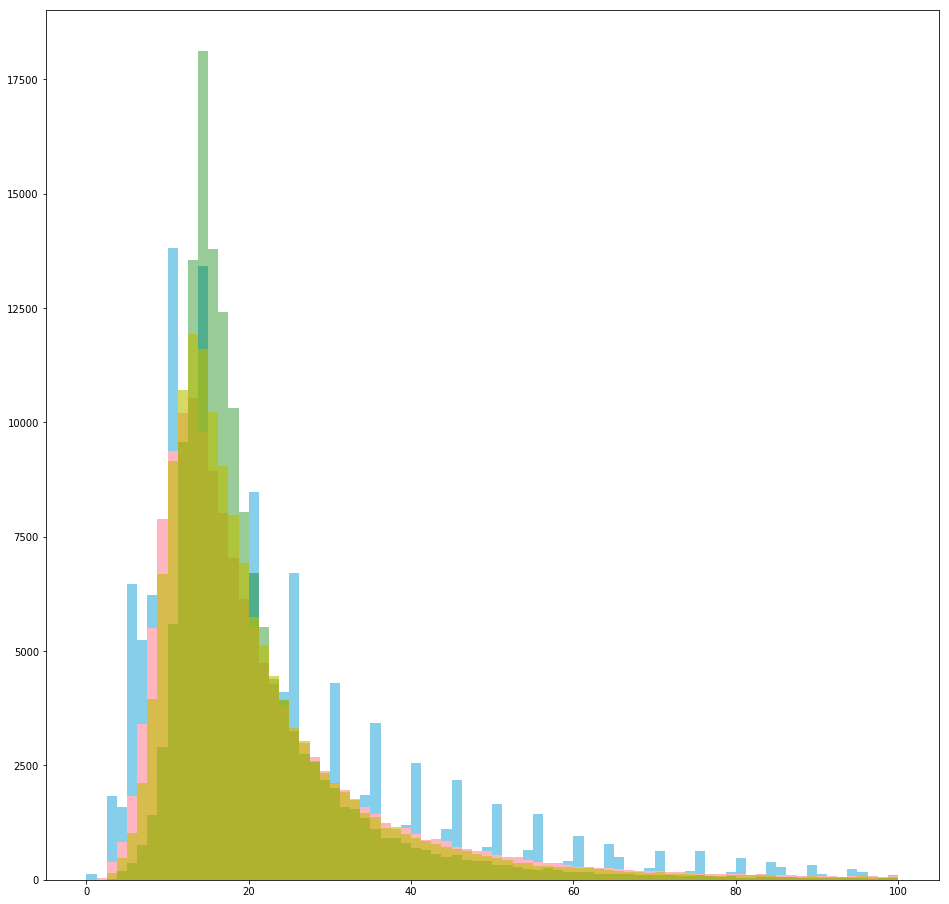

In [49]:

fig,ax = plt.subplots(figsize=(16,16))

ax.hist(actual_price,color='skyblue', alpha=1.0, bins=80, range = [0, 100],label='actual_price')
ax.hist(lightgbm_price,color='lightpink', alpha=1.0, bins=80, range = [0, 100],label='lightgbm_price')
ax.hist(xgb_price,color='g', alpha=0.4, bins=80, range = [0, 100],label='xgb_price')
ax.hist(combine_predict,color='y', alpha=0.6, bins=80, range = [0, 100],label='combine_predict')

plt.show()


In [0]:
# Plot the comparison of actual and predict prices 

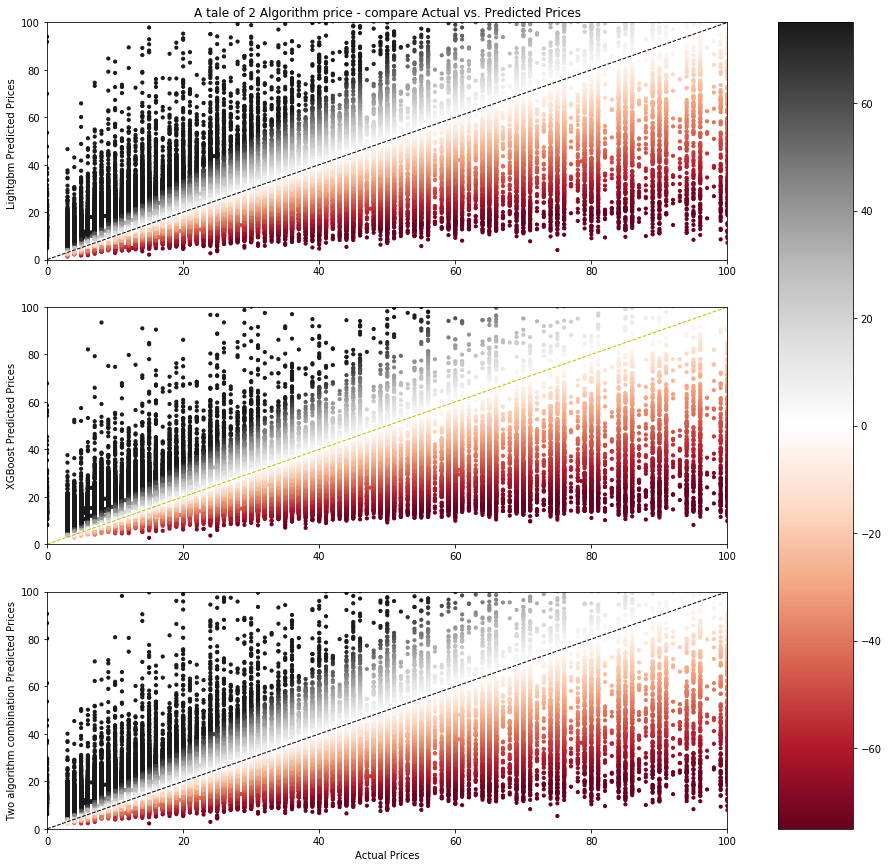

In [31]:
plt.figure(figsize=(14,14))
cm = plt.cm.get_cmap('RdGy')
ax1 = plt.subplot(311)
x_diff = np.clip(100 * ((lightgbm_price - actual_price) / actual_price), -75, 75)
plt.scatter(x=actual_price, y=lightgbm_price, c=x_diff, s=10, cmap=cm)
plt.plot([0, 100], [0, 100], 'k--', lw=1)
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.title('A tale of 2 Algorithm price - compare Actual vs. Predicted Prices')
plt.ylabel('Lightgbm Predicted Prices ')

ax2 = plt.subplot(312,sharex=ax1,sharey=ax1)

x_diff = np.clip(100 * ((xgb_price - actual_price) / actual_price), -75, 75)
plt.scatter(x=actual_price, y=xgb_price, c=x_diff, s=10, cmap=cm)
plt.plot([0, 100], [0, 100], 'y--', lw=1)
plt.ylabel('XGBoost Predicted Prices')

ax3 = plt.subplot(313, sharex=ax1,sharey=ax1)

x_diff = np.clip(100 * ((combine_predict - actual_price) / actual_price), -75, 75)
plt.scatter(x=actual_price, y=combine_predict, c=x_diff, s=10, cmap=cm)
plt.plot([0, 100], [0, 100], 'k--', lw=1)

plt.xlabel('Actual Prices')
plt.ylabel('Two algorithm combination Predicted Prices')

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.85, 0.1, 0.075, 0.8])
plt.colorbar(cax=cax)

plt.show()